# Vehicle Type Classification

Z. Luo et. al. 2018. MIO-TCD: A New Benchmark Dataset for Vehicle Classification and Localization. Retrieved from https://ieeexplore.ieee.org/abstract/document/8387876
<br>
<br>
Dataset @ http://podoce.dinf.usherbrooke.ca/challenge/dataset/

In [1]:
# required libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "http://podoce.dinf.usherbrooke.ca/static/dataset/MIO-TCD-Classification.tar"
data_dir = tf.keras.utils.get_file('MIO-TCD-Classification', origin=dataset_url, untar=True)
print(data_dir)

3117244416/3117240320 [==============================] - 76s 0us/step
/root/.keras/datasets/MIO-TCD-Classification


### Folder Structure

*   test/
  * L XXXXXXX.jpg
  * L ...
*   train/
  * articulated_truck/
  * L 0000000001.jpg
  * L 0000000002.jpg
  * L ...
  * background/
  * ...


In [3]:
data_dir = pathlib.Path("/root/.keras/datasets/train")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

519164


### Displaying some examles

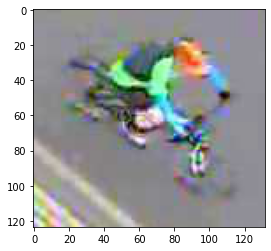

In [5]:
bicycles = list(data_dir.glob('bicycle/*'))
im = plt.imread(str(bicycles[0]))
plt.imshow(im)

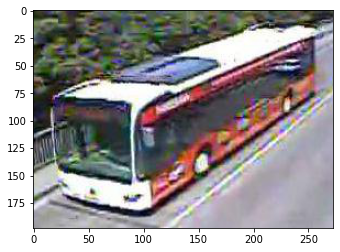

In [6]:
busses = list(data_dir.glob('bus/*'))
im = plt.imread(str(busses[0]))
plt.imshow(im)

### Creating a dataset

In [7]:
# parameters for the loader

batch_size = 32
img_height = 256
img_width = 256

splitting the images in order to use 80% of the images for training, and 20% for validation

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.85,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  smart_resize=True,
  batch_size=batch_size)

Found 519164 files belonging to 11 classes.
Using 77875 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 519164 files belonging to 11 classes.
Using 51916 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['articulated_truck', 'background', 'bicycle', 'bus', 'car', 'motorcycle', 'non-motorized_vehicle', 'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']


### Visulizing the data

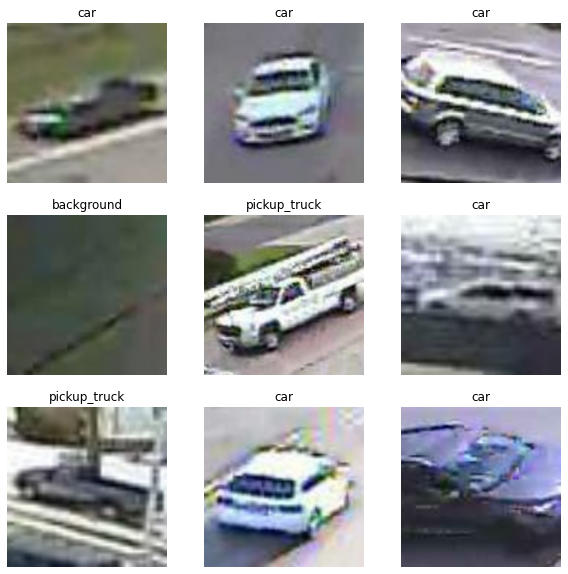

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
# training dataset structure

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


The image_batch is a tensor of the shape (32, 256, 256, 3). This is a batch of 32 images of shape 256x256x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

### Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarizing the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make your input values small. Here, we will standardize values to be in the [0, 1] range by using a Rescaling layer

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


now the values are between 0 and 1

## Creating the Model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiling the Model

We are using the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary
View all the layers of the network using the model's summary method:


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

## Training the model

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2434/2434 [==============================] - 168s 63ms/step - loss: 0.6270 - accuracy: 0.8089 - val_loss: 0.4697 - val_accuracy: 0.8492
Epoch 2/10
2434/2434 [==============================] - 151s 62ms/step - loss: 0.3738 - accuracy: 0.8803 - val_loss: 0.4479 - val_accuracy: 0.8587
Epoch 3/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.2287 - accuracy: 0.9252 - val_loss: 0.5384 - val_accuracy: 0.8614
Epoch 4/10
2434/2434 [==============================] - 151s 62ms/step - loss: 0.1365 - accuracy: 0.9549 - val_loss: 0.7097 - val_accuracy: 0.8549
Epoch 5/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.0929 - accuracy: 0.9701 - val_loss: 0.7814 - val_accuracy: 0.8579
Epoch 6/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.0674 - accuracy: 0.9784 - val_loss: 0.9043 - val_accuracy: 0.8619
Epoch 7/10
2434/2434 [==============================] - 152s 62ms/step - loss: 0.0562 - accuracy: 0.9814 - val_loss: 0

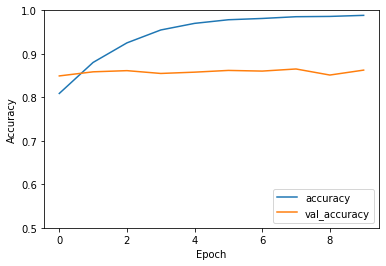

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

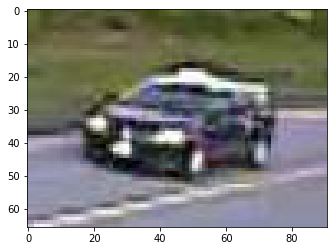

In [40]:
test_dir = pathlib.Path("/root/.keras/datasets/test")

test_images = list(test_dir.glob('*'))
im = plt.imread(str(test_images[0]))
plt.imshow(im)

In [41]:
# 256, 256
size = (img_height, img_width)

def predict_image(x):
  """predict a given image"""
  
  img = tf.keras.preprocessing.image.smart_resize(x, size)
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return (class_names[np.argmax(score)], round(100 * np.max(score), 2))
  

In [42]:
cls, score = predict_image(im)
print(f'This image most likely belongs to {cls} with a {score} percent confidence.')

This image most likely belongs to car with a 100.0 percent confidence.


In [44]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [45]:
model.save('vehicle_model.h5')